In [1]:
import os
import utils
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pingouin as pg
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut,cross_validate

sns.set_style('white')
sns.set_context('poster')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [2]:
def star(x):
    if x < 0.001:
        return "***"
    elif x < 0.01:
        return "**"
    elif x < 0.05:
        return "*"
    else:
        return 'n.s.'
order_x = ['Hummed\ntones',
           'Simple vowel\ntones',
           'CV Pseudo-word\ntones',
           'CV word\ntones']
figures_dir     = '../figures'
dpi = 500
replacement = {"experiment":"experiment",
               "side":"side of ears",
               "condition":"condition",
               "Exp. 1":"experiment 1",
               "Exp. 2":"experiment 2"}

# Figure 3

In [3]:
df_figure_3 = pd.read_csv('../results/for_figure3.csv')
df_figure_3_RT = pd.read_csv('../results/for_figure3_RT.csv')

## mixed effect ANOVA

1. correct rate ~ experiment * side
2. RT ~ experiment * side

In [4]:
# correct rate ~ experiment * side
aov_3 = pg.mixed_anova(data = df_figure_3,
                       dv = 'correct_rate',
                       within = 'side',
                       between = 'experiment',
                       subject = 'sub_name',
                       )
aov_3['sig'] = aov_3['p-unc'].apply(star)
# RT ~ experiment * side
aov_3_RT = pg.mixed_anova(data = df_figure_3_RT,
                       dv = 'RT',
                       within = 'side',
                       between = 'experiment',
                       subject = 'sub_name',
                       )
aov_3_RT['sig'] = aov_3_RT['p-unc'].apply(star)
print('correct rate ~ experiment * side')
print(aov_3)
print()
print("RT ~ experiment * side")
print(aov_3_RT)

empty = ""
for ii,row in aov_3.iterrows():
    if row['sig'] != 'n.s.':
        empty += f"there was a main effect of {replacement[row['Source']]}, F({row['DF1']},{row['DF2']}) = {row['F']:.3f}, p = {row['p-unc']:.6f}, eta square = {row['np2']}\n"

correct rate ~ experiment * side
        Source     SS  DF1  DF2     MS      F     p-unc    np2 eps   sig
0   experiment  0.000    1   41  0.000  0.000  1.000000  0.000   -  n.s.
1         side  0.136    1   41  0.136  9.897  0.003079  0.194   1    **
2  Interaction  0.003    1   41  0.003  0.189  0.666131  0.005   -  n.s.

RT ~ experiment * side
        Source     SS  DF1  DF2     MS      F     p-unc    np2 eps   sig
0   experiment  0.012    1   41  0.012  0.060  0.807731  0.001   -  n.s.
1         side  0.003    1   41  0.003  0.382  0.540013  0.009   1  n.s.
2  Interaction  0.012    1   41  0.012  1.517  0.225125  0.036   -  n.s.


## t-test of left and right ear advantage in experiment 1 and experiment 2

In [5]:
posthoc3 = pg.pairwise_ttests(dv='correct_rate', within='experiment', between='side',
                   subject='sub_name', data=df_figure_3, padjust='fdr_bh',
                   )
posthoc3['sig'] = posthoc3['p-corr'].apply(star)
print(posthoc3)
empty += "A post-hoc comparison between the left and right ear effect within each experiment showed that there were significant differences between the left ear and right ear in each experiment.\n"
for ii,row in posthoc3.iterrows():
    if row['sig'] != 'n.s.':
        print(f"{row['experiment']} t({int(row['dof']/2-1)}) = {row['T']:.3f}, p = {row['p-unc']:.4f}, corrected p = {row['p-corr']:.4f}")
        empty += f"{replacement[row['experiment']]} t({int(row['dof']/2-1)}) = {row['T']:.3f}, p = {row['p-unc']:.4f}, corrected p = {row['p-corr']:.4f}\n"


            Contrast experiment       A       B  Paired  Parametric      T  \
0         experiment          -  Exp. 1  Exp. 2    True        True  0.183   
1               side          -    left   right   False        True  3.712   
2  experiment * side     Exp. 1    left   right   False        True  2.368   
3  experiment * side     Exp. 2    left   right   False        True  2.851   

     dof       Tail     p-unc    p-corr p-adjust    BF10  hedges   sig  
0  81.77  two-sided  0.855195       NaN      NaN   0.229   0.039  n.s.  
1  84.00  two-sided  0.000369       NaN      NaN  71.009   0.793  n.s.  
2  44.00  two-sided  0.022350  0.022350   fdr_bh   2.644   0.686     *  
3  38.00  two-sided  0.007013  0.014026   fdr_bh   6.533   0.884     *  
Exp. 1 t(21) = 2.368, p = 0.0223, corrected p = 0.0223
Exp. 2 t(18) = 2.851, p = 0.0070, corrected p = 0.0140


C:\Anaconda3\lib\site-packages\pingouin\parametric.py:198: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to "
C:\Anaconda3\lib\site-packages\pingouin\effsize.py:672: UserWarning: x and y have unequal sizes. Switching to paired == False.
  warnings.warn("x and y have unequal sizes. Switching to "


res_3 = dict(t=[],
             p=[],
             exp=[],
             dof=[],)
for exp,df_sub in df_figure_3.groupby(['experiment']):
    df_sub = df_sub.sort_values(['sub_name','side'])
    left = df_sub[df_sub['side']=='left']['correct_rate'].values
    right = df_sub[df_sub['side']=='right']['correct_rate'].values
    t,p = stats.ttest_rel(left,right,)
    res_3['t'].append(t)
    res_3['p'].append(p)
    res_3['exp'].append(exp)
    res_3['dof'].append(df_sub.shape[0] / 2 - 1)
res_3 = pd.DataFrame(res_3)
res_3 = res_3.sort_values(['p'])
coverter = utils.MCPConverter(pvals = res_3['p'].values)
d = coverter.adjust_many()
res_3['p_corrected'] = d['bh'].values # multiple comparison correction
res_3 = res_3.sort_values('exp')
for exp,df_sub in res_3.groupby('exp'):
    print(f"{exp} t({int(df_sub['dof'].values[0])}) = {df_sub['t'].values[0]:.3f}, p = {df_sub['p'].values[0]:.4f}, corrected p = {df_sub['p_corrected'].values[0]:.4f}")
    empty += f"{exp} t({int(df_sub['dof'].values[0])}) = {df_sub['t'].values[0]:.3f}, p = {df_sub['p'].values[0]:.4f}, corrected p = {df_sub['p_corrected'].values[0]:.4f}\n"


In [6]:
empty += "Multiple comparisons were corrected by BH-FDR\n*:p < 0.05, **: p < 0.01"
fig3_summary = f'{empty}'

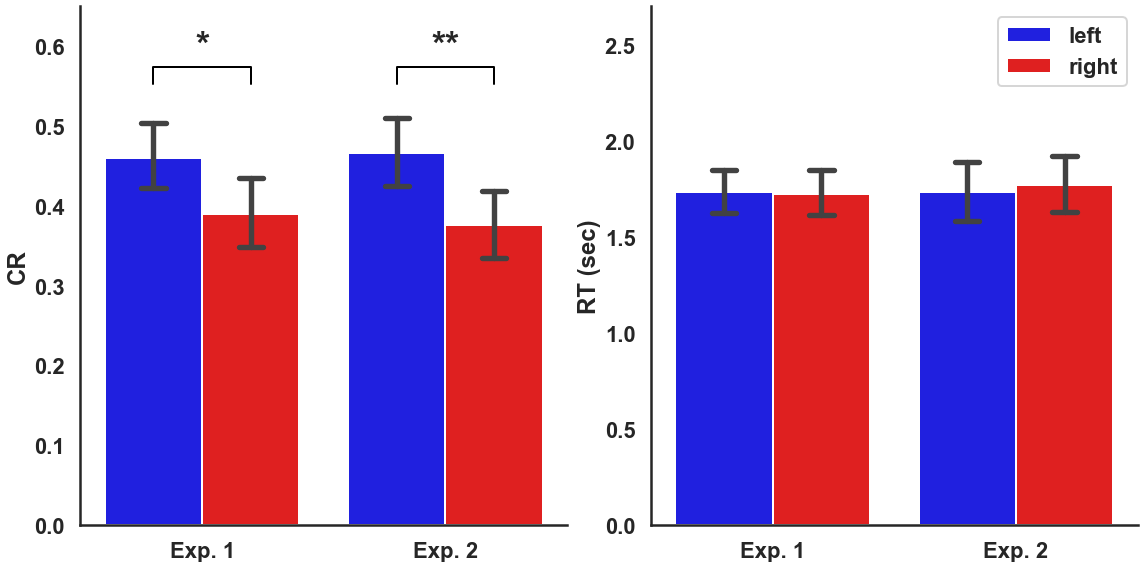

In [7]:
###### pre-define some common arguments that we will repeat over and over again #########
args = dict(x = 'experiment', # x axis
            hue = 'side', # split the bars
            palette = {'left':'blue','right':'red'}, # bar color
            capsize = .1, # errorbar capsize
           )
###### common arguments for annotation ########
annotate_args = dict(xycoords='data',
                     textcoords='data',
                     arrowprops=dict(arrowstyle="-", ec='black',
                                    connectionstyle="bar,fraction=0.2"))
###### common arguments for adding the stars #######
text_args = dict(weight = 'bold',
                 horizontalalignment='center',
                 verticalalignment='center',
                 size = 36,)

fig,axes = plt.subplots(figsize = (16,8),ncols = 2,) # define the figure with 2 columns subplots
# subplot (2,1,1) --> correct rate ~ experiment * side
ax = axes[0]
line_height = .55
text_height = .6
ax = sns.barplot(y = 'correct_rate',
                 data = df_figure_3,
                 ax = ax,
                 **args)
ax.set(ylim =(0,0.65),
       ylabel = 'CR',
       xlabel = '',)
ax.annotate("", xy=(-.2, line_height), 
            xytext=(.2, line_height), 
            **annotate_args)
ax.text(0, .6, "*",
       **text_args)
ax.annotate("", xy=(1-.2, line_height),
            xytext=(1+.2, line_height), 
            **annotate_args)
ax.text(1, text_height, "**",
       **text_args)
ax.get_legend().remove()
sns.despine()
# RT
ax = axes[1]
ax = sns.barplot(y = 'RT',
                 data = df_figure_3_RT,
                 ax = ax,
                 **args)
ax.set(ylim =(0,2.7),
       ylabel = 'RT (sec)',
       xlabel = '',)
ax.legend(loc = 'upper right')
sns.despine()
fig.tight_layout()
fig.savefig(os.path.join(figures_dir,'figure 3.jpeg'),
            dpi         = dpi,
            bbox_inches = 'tight',)

In [8]:
print(fig3_summary)

there was a main effect of side of ears, F(1,41) = 9.897, p = 0.003079, eta square = 0.194
A post-hoc comparison between the left and right ear effect within each experiment showed that there were significant differences between the left ear and right ear in each experiment.
experiment 1 t(21) = 2.368, p = 0.0223, corrected p = 0.0223
experiment 2 t(18) = 2.851, p = 0.0070, corrected p = 0.0140
Multiple comparisons were corrected by BH-FDR
*:p < 0.05, **: p < 0.01


# Figure 4

In [9]:
df_figure_4 = pd.read_csv('../results/for_figure4.csv')
df_figure_4_RT = pd.read_csv('../results/for_figure4_RT.csv')

# Apply a repeated measured ANOVA on correct rate as a factor of codition and side of ears in experiment 2

In [10]:
resRM_4 = pg.rm_anova(data = df_figure_4,
                      dv = 'correct_rate',
                      subject = 'sub_name',
                      within = ['condition','side'],
                      )
resRM_4['sig'] = resRM_4['p-GG-corr'].apply(star)
print(resRM_4)
empty = ""
for ii,row in resRM_4.iterrows():
    if row['sig'] != 'n.s.':
        empty += f"there was a main effect of {replacement[row['Source']]}, F({row['ddof1']},{row['ddof2']}) = {row['F']:.4f}, p = {row['p-unc']:.4f}, corrected p = {row['p-GG-corr']:.4f}, eta sqaure = {row['np2']:.4f}\n"


             Source     SS  ddof1  ddof2     MS      F     p-unc  p-GG-corr  \
0         condition  0.055      3     57  0.018  9.856  0.000025   0.000091   
1              side  0.101      1     19  0.101  4.641  0.044269   0.044269   
2  condition * side  0.051      3     57  0.017  1.193  0.320436   0.317747   

     np2    eps   sig  
0  0.342  0.837   ***  
1  0.196  1.000     *  
2  0.059  0.792  n.s.  


## Post-hoc test of the main effect of condition

In [11]:
post_4 = pg.pairwise_ttests(data = df_figure_4,
                   dv = 'correct_rate',
                   within = ['condition','side'],
                   padjust ='fdr_bh', # multiple comparison correction
                   alpha = 0.05,
                   effsize= 'eta-square',
                   interaction = False,
                   parametric = True,)
post_4['sig'] = post_4['p-unc'].apply(star)
post_4 = post_4.sort_values('p-unc')
print(post_4[[ 'A', 'B', 'T', 'dof','p-unc', 'p-corr','sig']].iloc[1:,:])
empty += "From a post-hoc comparison within each main effect:\n"
for ii,row in post_4.iterrows():
    if row['sig'] != 'n.s.':
        empty += f"there was a significant difference between {row['A']} and {row['B']}, t({int(row['dof'])}) = {row['T']:.3f}, p = {row['p-unc']:4f}, corrected p = {row['p-corr']:.4f}\n"

                       A                      B      T   dof     p-unc  \
5          Hummed\ntones    Simple vowel\ntones -2.214  39.0  0.032729   
2         CV word\ntones    Simple vowel\ntones -2.191  39.0  0.034498   
0         CV word\ntones  CV Pseudo-word\ntones -1.288  39.0  0.205357   
4  CV Pseudo-word\ntones    Simple vowel\ntones -1.169  39.0  0.249559   
3  CV Pseudo-word\ntones          Hummed\ntones  0.651  39.0  0.518751   
1         CV word\ntones          Hummed\ntones -0.333  39.0  0.740898   

     p-corr   sig  
5  0.103493     *  
2  0.103493     *  
0  0.374339  n.s.  
4  0.374339  n.s.  
3  0.622501  n.s.  
1  0.740898  n.s.  


In [12]:
pg.pairwise_ttests(data = df_figure_4,
                   dv = 'correct_rate',
                   within = ['condition','side'],
                   padjust ='fdr_bh', # multiple comparison correction
                   alpha = 0.05,
                   effsize= 'eta-square',
                   interaction = True,
                   parametric = True,)

,Contrast,condition,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,condition,-,CV word\ntones,CV Pseudo-word\ntones,True,True,-1.288,39.0,two-sided,0.205357,0.374339,fdr_bh,0.367,0.011
1,condition,-,CV word\ntones,Hummed\ntones,True,True,-0.333,39.0,two-sided,0.740898,0.740898,fdr_bh,0.18,0.001
2,condition,-,CV word\ntones,Simple vowel\ntones,True,True,-2.191,39.0,two-sided,0.034498,0.103493,fdr_bh,1.445,0.058
3,condition,-,CV Pseudo-word\ntones,Hummed\ntones,True,True,0.651,39.0,two-sided,0.518751,0.622501,fdr_bh,0.208,0.004
4,condition,-,CV Pseudo-word\ntones,Simple vowel\ntones,True,True,-1.169,39.0,two-sided,0.249559,0.374339,fdr_bh,0.321,0.015
5,condition,-,Hummed\ntones,Simple vowel\ntones,True,True,-2.214,39.0,two-sided,0.032729,0.103493,fdr_bh,1.509,0.034
6,side,-,left,right,True,True,2.494,79.0,two-sided,0.014711,NaN,NaN,2.238,0.056
7,condition * side,CV word\ntones,left,right,True,True,0.164,19.0,two-sided,0.871223,0.871223,fdr_bh,0.235,0.001
8,condition * side,CV Pseudo-word\ntones,left,right,True,True,0.564,19.0,two-sided,0.579303,0.772403,fdr_bh,0.268,0.012
9,condition * side,Hummed\ntones,left,right,True,True,2.342,19.0,two-sided,0.030208,0.120831,fdr_bh,2.072,0.169


## Post-hoc test of ear effect in Hummed tone and simple voxel tone condition separately

pose_side_4 = dict(condition = [],
                   t = [],
                   p = [],)
# left and right in hum and tone
for condition in order_x[:2]:
    df_sub = df_figure_4[df_figure_4['condition'] == condition]
    df_sub = df_sub.sort_values(['sub_name','side'])
    left = df_sub[df_sub['side'] == 'left']['correct_rate'].values
    right = df_sub[df_sub['side'] == 'right']['correct_rate'].values
    t,p = stats.ttest_rel(left,right)
    pose_side_4['condition'].append(condition)
    pose_side_4['t'].append(t)
    pose_side_4['p'].append(p)
pose_side_4 = pd.DataFrame(pose_side_4)
pose_side_4 = pose_side_4.sort_values('p')
converter = utils.MCPConverter(pvals = pose_side_4['p'].values)
d = converter.adjust_many()
pose_side_4['correct_p'] = d['bh'] # multiple comparison correction
for condition, df_sub in pose_side_4.groupby('condition'):
    condition = condition.replace('\n',' ')
    print(f"{condition:.12s}, t = {df_sub['t'].values[0]:.3f}, p = {df_sub['p'].values[0]:.4f}, correct p = {df_sub['correct_p'].values[0]:.4f}")

## Apply the repeated measure ANOVA on LEA as a factor of condition

In [13]:
empty += "we apply a repeated measure ANOVA on LEA as a factor of condition\n"
rmRes_4 = pg.rm_anova(data = pd.read_csv('../results/for_figure5.csv'),
                      dv = 'LEA',
                      within = 'condition',
                      subject = 'sub_name',)
print(rmRes_4)
for ii,row in rmRes_4.iterrows():
    if row['p-unc'] < 0.05:
        empty += f"there was a main effect of {row['Source']}, F({row['ddof1']},{row['ddof2']}) = {row['F']:.3f}, p = {row['p-unc']:.4f}, eta square = {row['np2']:.4f}\n"
post_rm_LEA_4 = pg.pairwise_ttests(data = pd.read_csv('../results/for_figure5.csv'),
                      dv = 'LEA',
                      within = 'condition',
                      padjust ='fdr_bh', # multiple comparison correction
                       alpha = 0.05,
                       effsize= 'eta-square',
                       interaction = False,
                       parametric = True,)
post_rm_LEA_4['sig'] = post_rm_LEA_4['p-unc'].apply(star)
post_rm_LEA_4 = post_rm_LEA_4.sort_values('p-unc')
print(post_rm_LEA_4[['A','B',"T",'dof','p-unc','p-corr','sig']])
empty += 'From a post-hoc test comparison between each pair of conditions\n'
for ii, row in post_rm_LEA_4.iterrows():
    if row['sig'] != 'n.s.':
        empty += f"there was a marginally significant difference between {row['A']} and {row['B']}\n"
        empty += f"t({int(row['dof'])}) = {row['T']:.3f}, p = {row['p-unc']:.4f}, corrected p = {row['p-corr']:.4f}"

      Source  ddof1  ddof2      F     p-unc    np2   eps
0  condition      3     57  3.547  0.019972  0.157  0.82
                       A                      B      T   dof     p-unc  \
2         CV word\ntones    Simple vowel\ntones -2.661  19.0  0.015421   
1         CV word\ntones          Hummed\ntones -1.913  19.0  0.070909   
4  CV Pseudo-word\ntones    Simple vowel\ntones -1.825  19.0  0.083824   
0         CV word\ntones  CV Pseudo-word\ntones -1.474  19.0  0.156933   
5          Hummed\ntones    Simple vowel\ntones -1.428  19.0  0.169517   
3  CV Pseudo-word\ntones          Hummed\ntones -0.730  19.0  0.474350   

     p-corr   sig  
2  0.092528     *  
1  0.167648  n.s.  
4  0.167648  n.s.  
0  0.203420  n.s.  
5  0.203420  n.s.  
3  0.474350  n.s.  


In [14]:
fig4_summary = f"{empty}"

In [ ]:
fig,axes = plt.subplots(figsize = (16,16),nrows = 2)
args = dict(x = 'condition',
            order = order_x,
            capsize = .1,
            palette = {'left':'blue','right':'red'},
            hue = 'side',)
# response
ax = axes[0]
ax = sns.barplot(
                 y = 'correct_rate',
                 data = df_figure_4,
                 ax = ax,
                 **args
                 )
ax.set(xlabel = '',
       xticklabels = [],
       ylabel = 'CR',
       ylim = (0,0.67),
       )
ax.legend(loc = 'upper right')
sns.despine()
line_height = .5
text_height = .6

ax.annotate("", xy=(0, line_height),
            xytext=(0.99, line_height),
           **annotate_args)
ax.text(0.5, text_height, "*",
       **text_args)

ax.annotate("", xy=(1.01, line_height),
            xytext=(3, line_height), 
           **annotate_args)
ax.text(2, text_height, "*",
       **text_args)
# RT
ax = axes[1]
ax = sns.barplot(
                 y = 'RT',
                 data = df_figure_4_RT,
                 ax = ax,
                 **args
                 )
ax.set(xlabel = '',
       ylabel = "RT")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(),
                   rotation = -35, 
                   ha = 'center',
                   weight = 'bold')
ax.get_legend().remove()
sns.despine()
fig.savefig(os.path.join(figures_dir,
                        'figure 4.jpeg'),
           dpi = dpi,
           bbox_inches = 'tight')

# Figure 5

In [ ]:
df_figure_5 = pd.read_csv('../results/for_figure5.csv')

In [ ]:
df_figure_5.sort_values('n_condition')

In [ ]:
t,p = stats.ttest_1samp(df_figure_5['adjust_LI'].values,0)
print(f"t = {t:.3f}, p = {p:.4f}")

In [ ]:
lm = linear_model.LinearRegression()
cv = LeaveOneOut()
x=df_figure_5['n_condition'].values.reshape(-1,1)
y = df_figure_5['LI'].values
#y = (y - y.mean()) / y.std()
groups = df_figure_5['sub_name']
res = cross_validate(lm,x,y,
                     groups = groups,
                     cv = cv,
                     return_estimator = True,
                     scoring = 'neg_mean_squared_error')
score = res['test_score']
baseline = np.array([(y_true - y.mean())**2 for y_true in y])
weights = np.array([reg.coef_[0] for reg in res['estimator']])
intercepts = np.array([reg.intercept_ for reg in res['estimator']])
t,p = stats.ttest_1samp(weights,0)
print(f"t = {t:.3f}, p = {p:.2e}")
_=plt.hist(weights)

In [ ]:
fig5_summary = f"""
We applied a cross-validation procedure to estimate the linear trend of the relation between the conditions and LI. 
For each cross-validation iteration, we selected one of the 20 subjects and removed this data point from fitting the linear regression. 
We used the rest of the 19 subjects' data to fit a linear regression to predict LI as a function of condition. 
Such iteration was repeated until all the subjects were removed from the fitting dataset once, thus, we had 20 linear regression functions. 
We then compare the regression coefficients of the linear regression functions against zero by a one-sample t-test, 
and the average of the coefficients was significantly different from zero, t({19}) = {t:.3f}, p = {p:.2e}. 
On figure 5, we showed the average estimated linear regression function by a dotted line and shaded the standard error of the estimate with upper and lower bounds (in red). ***: p < 0.0001 
"""
print(fig5_summary.replace('\n',''))

In [ ]:
fig,ax = plt.subplots(figsize = (16,8),)
ax = sns.pointplot(x = 'condition',
                   order = order_x,
                   y = 'LI',
                   data = df_figure_5,
                   ax = ax,
                   markers = '.',
                   capsize = .1,
                   color = 'black',
                   alpha = 0.4,)
xx = np.linspace(0,3,100)
yy = np.dot(xx.reshape(-1,1),weights.reshape(1,-1)) + intercepts
yy_upper = yy.max(1)
yy_lower = yy.min(1)
ax.plot(xx,yy.mean(1),
        color = 'black',
        linestyle = '--',
        label = 'estimated trend (mean)')
ax.fill_between(xx,
                yy_upper,
                yy_lower,
                color = 'red',
                label = 'estimated trend (SE)',
                )
ax.annotate('***',
            xy = (1.5,0.2),
            size = 36,
            weight = 'bold')
ax.legend(loc = 'upper right')
ax.set(xlabel = '',
       ylabel = 'LI',
       ylim = (-0.1,0.25),)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(),
                   rotation = -35, 
                   ha = 'center',
                   weight = 'bold')
sns.despine()
fig.savefig(os.path.join(figures_dir,
                        'figure 5.jpeg'),
           dpi = dpi,
           bbox_inches = 'tight')

In [ ]:
readme_template = """# This repository is in responding to "Lateralization in the dichotic listening of tones is influenced by the content of speech"

# Figure 3
![fig3](https://github.com/nmningmei/dichotic-listening-of-tones-is-influenced-by-the-content-of-speech/blob/master/figures/figure%203.jpeg)

{}

# Figure 4
![fig4](https://github.com/nmningmei/dichotic-listening-of-tones-is-influenced-by-the-content-of-speech/blob/master/figures/figure4.jpeg)


{}

# Figure 5
![fig5](https://github.com/nmningmei/dichotic-listening-of-tones-is-influenced-by-the-content-of-speech/blob/master/figures/figure5.jpeg)

{}
""".format(fig3_summary,fig4_summary,fig5_summary)

In [ ]:
with open('../README.md','w') as f:
    f.write(readme_template)
    f.close()